In [22]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
from tqdm import tqdm
import os
import random
from sklearn.manifold import TSNE
from collections import defaultdict

In [23]:
domains = ["Art", "Clip Art", "Real World"]

NUM_CLASSES = 65
BATCH_SIZE = 32
NUM_EPOCHS = 10
LEARNING_RATE = 0.001
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

In [24]:
d_t = "Art"
d_s = "Real World"

device = "mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: mps


In [30]:
model = torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights.IMAGENET1K_V1)
model.fc = nn.Linear(model.fc.in_features, NUM_CLASSES)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
loss_fn = nn.CrossEntropyLoss()
model = model.to(device)

In [25]:
def train_loop(dataloader, model, loss_fn, optimizer, device):
    model.to(device)
    model.train()
    losses = []
    accuracies = []
    for x, y in tqdm(dataloader):
        x, y = x.to(device), y.to(device)

        pred = model(x)
        loss = loss_fn(pred, y)

        losses.append(loss.item())
        accuracies.append((pred.argmax(1) == y).float().mean().item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return np.mean(losses), np.mean(accuracies)

def evaluate(dataloader, model, loss_fn, device):
    model.to(device)
    model.eval()
    losses = []
    accuracies = []
    with torch.no_grad():
        for x, y in tqdm(dataloader):
            x, y = x.to(device), y.to(device)

            pred = model(x)
            loss = loss_fn(pred, y)

            losses.append(loss.item())
            accuracies.append((pred.argmax(1) == y).float().mean().item())
    return np.mean(losses), np.mean(accuracies)

In [26]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
])

source_folder = os.path.join("officehome", d_s)
target_folder = os.path.join("officehome", d_t)

train_dataset = torchvision.datasets.ImageFolder(source_folder, transform=transform)
test_dataset = torchvision.datasets.ImageFolder(target_folder, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)


In [21]:
train_accuracies = []
train_losses = []
test_accuracies = []
test_losses = []

for i in range(NUM_EPOCHS):
    train_loss, train_acc = train_loop(train_loader, model, loss_fn, optimizer, device)
    test_loss, test_acc = evaluate(test_loader, model, loss_fn, device)
    print(f"Epoch {i+1}/{NUM_EPOCHS}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)

100%|██████████| 76/76 [00:24<00:00,  3.09it/s]


Epoch 1/10, Train Loss: 3.5923, Train Acc: 0.1577, Test Loss: 4.3467, Test Acc: 0.1110


100%|██████████| 76/76 [00:24<00:00,  3.10it/s]


Epoch 2/10, Train Loss: 2.7029, Train Acc: 0.2998, Test Loss: 3.8464, Test Acc: 0.1391


100%|██████████| 76/76 [00:23<00:00,  3.22it/s]


Epoch 3/10, Train Loss: 2.2434, Train Acc: 0.3996, Test Loss: 4.1144, Test Acc: 0.1513


100%|██████████| 76/76 [00:24<00:00,  3.14it/s]


Epoch 4/10, Train Loss: 1.9110, Train Acc: 0.4629, Test Loss: 3.7804, Test Acc: 0.1913


100%|██████████| 76/76 [00:56<00:00,  1.35it/s]


Epoch 5/10, Train Loss: 1.5609, Train Acc: 0.5492, Test Loss: 4.1241, Test Acc: 0.1751


100%|██████████| 76/76 [00:57<00:00,  1.33it/s]


Epoch 6/10, Train Loss: 1.3109, Train Acc: 0.6136, Test Loss: 3.9988, Test Acc: 0.2084


100%|██████████| 76/76 [00:56<00:00,  1.34it/s]


Epoch 7/10, Train Loss: 1.0469, Train Acc: 0.6870, Test Loss: 3.7826, Test Acc: 0.2592


100%|██████████| 76/76 [00:31<00:00,  2.38it/s]


Epoch 8/10, Train Loss: 0.7751, Train Acc: 0.7663, Test Loss: 4.4758, Test Acc: 0.2281


100%|██████████| 76/76 [00:32<00:00,  2.32it/s]


Epoch 9/10, Train Loss: 0.6399, Train Acc: 0.8029, Test Loss: 4.4899, Test Acc: 0.2200


100%|██████████| 76/76 [00:31<00:00,  2.40it/s]

Epoch 10/10, Train Loss: 0.6049, Train Acc: 0.8101, Test Loss: 4.3898, Test Acc: 0.2367


In [22]:
torch.save(model, 'resnet50_base.pth')

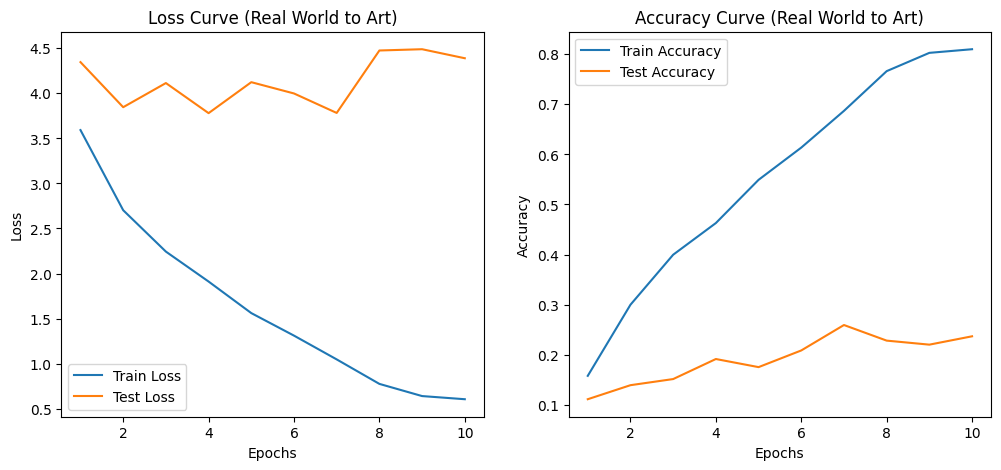

In [23]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, NUM_EPOCHS + 1), train_losses, label='Train Loss')
plt.plot(range(1, NUM_EPOCHS + 1), test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title(f'Loss Curve ({d_s} to {d_t})')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, NUM_EPOCHS + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, NUM_EPOCHS + 1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title(f'Accuracy Curve ({d_s} to {d_t})')
plt.legend()
plt.show()

# Concept Shift

In [28]:
def simulate_concept_shift(source_dataset, target_dataset, rare_fraction=0.2, removed_classes=5):
    np.random.seed(42)
    random.seed(42)

    # Unique class indices
    classes = list(range(len(source_dataset.classes)))

    # Pick random classes to remove from target (simulate label shift)
    removed = random.sample(classes, removed_classes)
    print(f"Removed classes from target: {removed}")

    # Rare class (under-represented)
    rare_class = random.choice([c for c in classes if c not in removed])
    print(f"Rare class in target: {rare_class}")

    # --- Filter target indices ---
    target_indices = []
    for i, (_, label) in enumerate(target_dataset):
        if label not in removed:
            if label == rare_class:
                # Keep only a small fraction of rare class
                if np.random.rand() < rare_fraction:
                    target_indices.append(i)
            else:
                target_indices.append(i)

    shifted_target = torch.utils.data.Subset(target_dataset, target_indices)
    return shifted_target


In [32]:
shifted_target_dataset = simulate_concept_shift(train_dataset, test_dataset, rare_fraction=0.2, removed_classes=5)
shifted_target_loader = torch.utils.data.DataLoader(shifted_target_dataset, batch_size=BATCH_SIZE, shuffle=True)

shifted_loss, shifted_acc = evaluate(shifted_target_loader, model, loss_fn, device)
print(f"Shifted Target Domain - Loss: {shifted_loss:.4f}, Accuracy: {shifted_acc:.4f}")

Removed classes from target: [14, 3, 35, 31, 28]
Rare class in target: 9


100%|██████████| 68/68 [00:21<00:00,  3.21it/s]

Shifted Target Domain - Loss: 4.4868, Accuracy: 0.2238


In [36]:
def per_class_accuracy(model, loader, device, class_names=None):
    model.eval()
    model.to(device)

    correct_per_class = defaultdict(int)
    total_per_class = defaultdict(int)

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            logits = outputs
            preds = torch.argmax(logits, dim=1)

            for label, pred in zip(labels, preds):
                total_per_class[label.item()] += 1
                if pred.item() == label.item():
                    correct_per_class[label.item()] += 1
        # Compute accuracy per class
    accuracies = {}
    for label in range(len(total_per_class)):
        total = total_per_class[label]
        correct = correct_per_class[label]
        acc = 100.0 * correct / total if total > 0 else 0.0
        name = class_names[label] if class_names is not None else str(label)
        accuracies[name] = acc

    return accuracies

class_names = test_loader.dataset.classes
print("Target: ", per_class_accuracy(model, test_loader, device, range(65)))
class_names = shifted_target_dataset.dataset.classes
print("Shifted Target", per_class_accuracy(model, shifted_target_loader, device, range(65)))

Target:  {0: 41.891891891891895, 1: 2.4390243902439024, 2: 33.333333333333336, 3: 15.0, 4: 28.0, 5: 10.1010101010101, 6: 15.0, 7: 27.272727272727273, 8: 50.0, 9: 75.0, 10: 7.246376811594203, 11: 24.0, 12: 13.636363636363637, 13: 47.5, 14: 17.5, 15: 0.0, 16: 40.0, 17: 22.22222222222222, 18: 19.047619047619047, 19: 11.11111111111111, 20: 50.0, 21: 15.217391304347826, 22: 45.55555555555556, 23: 20.0, 24: 4.3478260869565215, 25: 5.0, 26: 7.5, 27: 7.594936708860759, 28: 28.26086956521739, 29: 50.0, 30: 19.444444444444443, 31: 34.69387755102041, 32: 41.1764705882353, 33: 10.0, 34: 0.0, 35: 21.875, 36: 27.77777777777778, 37: 4.081632653061225, 38: 14.285714285714286, 39: 30.0, 40: 31.57894736842105, 41: 26.31578947368421, 42: 10.0, 43: 19.23076923076923, 44: 52.63157894736842, 45: 5.555555555555555, 46: 8.333333333333334, 47: 12.76595744680851, 48: 22.448979591836736, 49: 20.0, 50: 10.0, 51: 20.0, 52: 16.666666666666668, 53: 17.073170731707318, 54: 58.69565217391305, 55: 15.0, 56: 20.0, 57: 4

# Visualisation

In [31]:
with torch.serialization.safe_globals([torchvision.models.resnet50()]):
    model = torch.load("resnet50_base.pth", weights_only=False)

In [14]:
features_map = []
labels = []

def get_feature():
    def hook(model, input, output):
        features_map.append(output.detach().cpu())
    return hook

# Register hook
model_hook = model.avgpool.register_forward_hook(get_feature())

model.to(device)
model.eval()

def extract_features(loader, max_samples=1000):
    features_map.clear()
    labels.clear()

    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            _ = model(x)
            labels.extend(y.cpu().numpy())

            if len(labels) >= max_samples:
                break

    features = torch.cat(features_map, dim=0).view(len(labels), -1)[:max_samples]
    return features, labels[:max_samples]

# --- Extract features for train and test ---
train_features, train_labels = extract_features(train_loader, max_samples=1000)
test_features, test_labels = extract_features(test_loader, max_samples=1000)

# Remove hook after done
model_hook.remove()

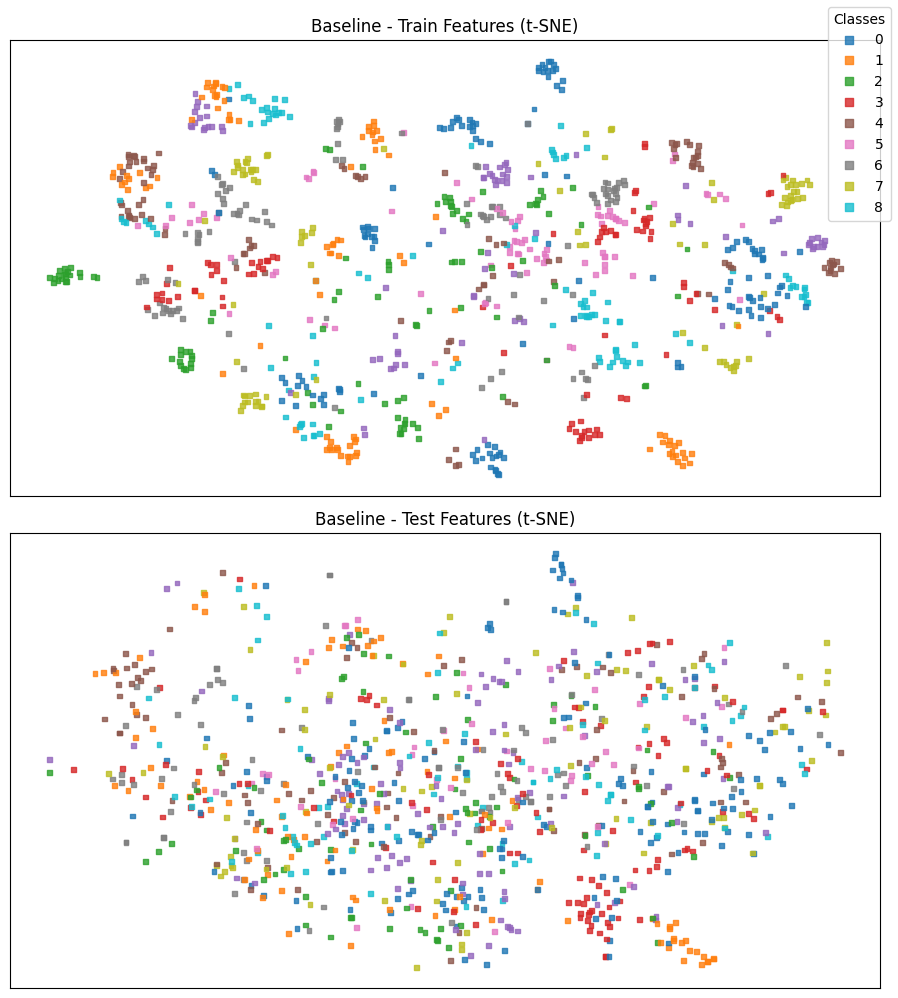

In [37]:
def plot_tsne(train_features, train_labels, test_features, test_labels, perplexity=30, random_state=42):
    # Convert tensors to numpy
    train_features = train_features.cpu().numpy() if hasattr(train_features, "cpu") else np.array(train_features)
    test_features = test_features.cpu().numpy() if hasattr(test_features, "cpu") else np.array(test_features)
    train_labels = np.array(train_labels)
    test_labels = np.array(test_labels)

    # Joint t-SNE for consistent space
    combined_features = np.concatenate([train_features, test_features], axis=0)
    combined_2d = TSNE(n_components=2, perplexity=perplexity, random_state=random_state).fit_transform(combined_features)

    n_train = len(train_features)
    train_2d, test_2d = combined_2d[:n_train], combined_2d[n_train:]

    # --- Plot side-by-side ---
    fig, axes = plt.subplots(2, 1, figsize=(9,10))

    scatter_train = axes[0].scatter(train_2d[:, 0], train_2d[:, 1],
                                    c=train_labels, cmap="tab10", s=12, marker='s', alpha=0.8)
    axes[0].set_title("Baseline - Train Features (t-SNE)")
    axes[0].set_xticks([])
    axes[0].set_yticks([])

    scatter_test = axes[1].scatter(test_2d[:, 0], test_2d[:, 1],
                                   c=test_labels, cmap="tab10", s=12, marker='s', alpha=0.8)
    axes[1].set_title("Baseline - Test Features (t-SNE)")
    axes[1].set_xticks([])
    axes[1].set_yticks([])

    # Shared legend for class colors
    handles, _ = scatter_train.legend_elements(prop="colors")
    fig.legend(handles, np.unique(train_labels), title="Classes", loc="upper right")

    plt.tight_layout()
    plt.show()

plot_tsne(train_features, train_labels, test_features, test_labels)